# Extracting attributes from Medical images

In [1]:
!git clone https://github.com/ruslan-kl/brain-tumor.git # load new data set and annotations
!pip install pycocotools
!git clone https://github.com/leekunhee/Mask_RCNN.git


fatal: destination path 'brain-tumor' already exists and is not an empty directory.
fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [1]:
import os 
import sys
from tqdm import tqdm
import cv2
import shutil
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
# Root directory of the project
ROOT_DIR = os.path.abspath('Mask_RCNN/')
# Import Mask RCNN
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize
from PIL import Image
import cv2
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco
from matplotlib.patches import Rectangle
!pip install pillow
from PIL import ImageDraw, ImageFont
plt.rcParams['figure.facecolor'] = 'white'
import json

Matplotlib created a temporary config/cache directory at /var/folders/q2/sns9phyn30n7mqn4s0zzvms40000gp/T/matplotlib-u7toehex because the default path (/Users/i516344/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
pd.set_option('display.max_colwidth', None)
from IPython.core.display import HTML
HTML("<style>.container { width:99% !important; }</style>")

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Data understanding

In [4]:
def create_dataset():
    patients_data = pd.DataFrame()
    patients_data['patient_id'] = []
    patients_data['image'] = []
    val_images = os.listdir('./brain-tumor/data/val')
    train_images = os.listdir('./brain-tumor/data/train')
    images_tumor = []
    for image in val_images:
        if len(image) == 8:
            images_tumor.append('./brain-tumor/data/val/' + image)
    for image in train_images:
        if len(image) == 8:
            images_tumor.append('./brain-tumor/data/train/' + image)
    patient_ids = [1,2,3,4,5,6,7,8,9,10]
    for i in patient_ids:
        img = np.random.choice(images_tumor, 10, replace=False)
        for image in img:
            patients_data.loc[len(patients_data.index)] = [i, image] 
    patients_data['patient_id'] = patients_data['patient_id'].astype(np.int64)
    patients_data['num_of_tumors'] = [None]*100
    patients_data['sizes'] = [None]*100
    patients_data['maximum_size'] = [None]*100
    patients_data['minimum_size'] = [None]*100
    patients_data['average_size'] = [None]*100
    patients_data['median_size'] = [None]*100
    patients_data['probability'] = [None]*100
    patients_data.style.set_properties(**{'text-align': 'left'})
    return patients_data

In [5]:
patients_data = create_dataset()
patients_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patient_id     100 non-null    int64 
 1   image          100 non-null    object
 2   num_of_tumors  0 non-null      object
 3   sizes          0 non-null      object
 4   maximum_size   0 non-null      object
 5   minimum_size   0 non-null      object
 6   average_size   0 non-null      object
 7   median_size    0 non-null      object
 8   probability    0 non-null      object
dtypes: int64(1), object(8)
memory usage: 11.9+ KB


In [6]:
patients_data.head(15)

,patient_id,image,num_of_tumors,sizes,maximum_size,minimum_size,average_size,median_size,probability
0,1,./brain-tumor/data/val/Y186.jpg,None,None,None,None,None,None,None
1,1,./brain-tumor/data/train/Y114.JPG,None,None,None,None,None,None,None
2,1,./brain-tumor/data/train/Y109.JPG,None,None,None,None,None,None,None
3,1,./brain-tumor/data/val/Y259.JPG,None,None,None,None,None,None,None
4,1,./brain-tumor/data/train/Y115.JPG,None,None,None,None,None,None,None
5,1,./brain-tumor/data/train/Y120.JPG,None,None,None,None,None,None,None
6,1,./brain-tumor/data/train/Y153.jpg,None,None,None,None,None,None,None
7,1,./brain-tumor/data/train/Y104.jpg,None,None,None,None,None,None,None
8,1,./brain-tumor/data/train/Y147.JPG,None,None,None,None,None,None,None
9,1,./brain-tumor/data/val/Y181.jpg,None,None,None,None,None,None,None


In [7]:
def display_datasample(patients_data):
    images = patients_data['image']
    sample = ['./brain-tumor/data/val/Y181.jpg', './brain-tumor/data/train/Y104.jpg', './brain-tumor/data/val/Y183.jpg', './brain-tumor/data/val/Y258.JPG' ]
    for image in sample:
        get_bboxes(image)
        
        

In [8]:
def get_bboxes(image):
    if image.find("val"):
        im = (image.split("/")[-1]).split(".")[0]
        data = './brain-tumor/data/annotations_all.json'
        with open(data) as f:
            data_json = json.load(f)
        for key in data_json.keys():
            num = key.split(".")[0]
            if num == im:
                print(im)
#                 print(data_json[key])
                x = data_json[key]['regions'][0]['shape_attributes']['all_points_x']
                y = data_json[key]['regions'][0]['shape_attributes']['all_points_y']
                print("size", data_json[key]['size'])
                minx = min(x)
                maxx = max(x)
                miny = min(y)
                maxy = max(y)
                bbox = [[minx,miny, maxx, maxy]]
                img = cv2.imread(image)
#                 cv2.imshow('key', img)
                draw_image_with_boxes(img, [], [0])
                print("-------------------------------------------------------")
def draw_image_with_boxes(filename, boxes_list, scores):
        
     # load the image
    data = filename
    fig, ax = plt.subplots()
    ax.imshow(data)

    # plot each box
    i = 0
    for box in boxes_list:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='red', lw=1)
        # draw the box
        ax.add_patch(rect)
        i = i + 1
     # show the plot
    plt.show()

# Dataset sample

Y181
size 17045


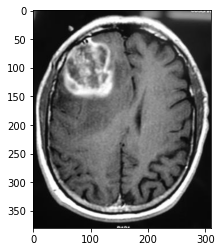

-------------------------------------------------------
Y104
size 98251


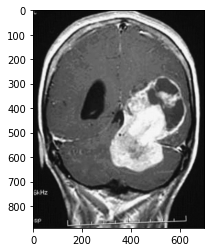

-------------------------------------------------------
Y183
size 32581


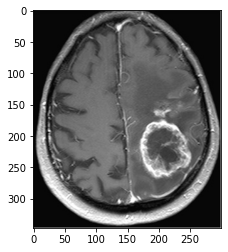

-------------------------------------------------------
Y258
size 23634


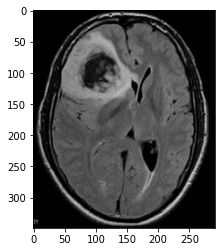

-------------------------------------------------------


In [9]:
display_datasample(patients_data)

# Model Configuration

In [10]:
class TumorConfig(Config):
    """Configuration for training on the brain tumor dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [11]:
def load_model():
    model = modellib.MaskRCNN(
        mode="inference", 
        config=config,
        model_dir='./model'
    )

    # Get path to saved weights
    # Either set a specific path or find last trained weights
    # model_path = os.path.join(ROOT_DIR, ".h5 file name here")
    # model_path = model.find_last()

    # Load trained weights
    print("Loading weights from ", './model/mask_rcnn_tumor_detector_0015.h5')
    model.load_weights('./model/mask_rcnn_tumor_detector_0015.h5', by_name=True)
    return model

In [12]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id)

    results = model.detect([original_image], verbose=0)
    r = results[0]
    return r

In [13]:
def getarea(box):
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    return round(width*height, 2)

# Extracting attributes from the images

In [14]:
def predict():
    image_list = patients_data['image']
    # image_list = ['./brain-tumor/data/val/Y242.JPG']
    i = 0
    hash_map = {}
    for image in image_list:
        imgloc = image
        if image in hash_map:
            patients_data.at[i, 'num_of_tumors'] = hash_map[image][0]
            patients_data.at[i, 'sizes'] =  hash_map[image][1]
            patients_data.at[i, 'probability'] =  hash_map[image][2]     
            i = i + 1
            continue
        img = cv2.imread(imgloc)
        res = cv2.resize(img, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
        r = model.detect([res], verbose=0)
        r = r[0]
        bbox = r['rois']
        probabilities = r['scores']
        rowbbox = ''
        rowscore = ''
        for j in range(0, len(bbox)):
            area = getarea(bbox[j])
            rowbbox = rowbbox + str(area) + ','
            rowscore = rowscore + str(round(probabilities[j], 3)) + ','
        rowbbox = rowbbox[ : len(rowbbox)-1]
        rowscore = rowscore[ : len(rowscore)-1]
        patients_data.at[i, 'num_of_tumors'] = len(bbox)
        if len(bbox) == 0:
            patients_data.at[i, 'sizes'] = '0'
        else:
            patients_data.at[i, 'sizes'] = rowbbox
        patients_data.at[i, 'probability'] = rowscore
        hash_map[image] = [len(bbox), rowbbox, rowscore]
        i = i + 1

In [15]:
model = load_model()

Instructions for updating:
Use fn_output_signature instead
Loading weights from  ./model/mask_rcnn_tumor_detector_0015.h5


In [16]:
predict()

/Users/i516344/.conda/envs/pythonProject/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [17]:
patients_data

,patient_id,image,num_of_tumors,sizes,maximum_size,minimum_size,average_size,median_size,probability
0,1,./brain-tumor/data/val/Y186.jpg,3,"4473,4686,43925",None,None,None,None,"0.989,0.989,0.93"
1,1,./brain-tumor/data/train/Y114.JPG,1,25024,None,None,None,None,0.994
2,1,./brain-tumor/data/train/Y109.JPG,1,47163,None,None,None,None,0.92
3,1,./brain-tumor/data/val/Y259.JPG,1,78876,None,None,None,None,0.951
4,1,./brain-tumor/data/train/Y115.JPG,2,"23701,86052",None,None,None,None,"0.982,0.889"
...,...,...,...,...,...,...,...,...,...
95,10,./brain-tumor/data/val/Y194.jpg,1,65762,None,None,None,None,0.861
96,10,./brain-tumor/data/val/Y259.JPG,1,78876,None,None,None,None,0.951
97,10,./brain-tumor/data/val/Y195.JPG,0,,None,None,None,None,
98,10,./brain-tumor/data/val/Y185.jpg,0,,None,None,None,None,


In [18]:
for index, row in patients_data.iterrows():
    if row['sizes'] is not None:
        sizes = row['sizes'].split(',')
        if sizes[0] == '':
            sizes = ['0']
        sizes = [int(size) for size in sizes]
        max_size = max(sizes)
        min_size = min(sizes)
        avg_size = round(np.mean(sizes), 3)
        med_size = round(np.median(sizes), 3)
        patients_data.at[index, 'maximum_size'] = max_size
        patients_data.at[index, 'minimum_size'] = min_size
        patients_data.at[index, 'average_size'] = avg_size     
        patients_data.at[index, 'median_size'] = med_size     



In [19]:
patients_data

,patient_id,image,num_of_tumors,sizes,maximum_size,minimum_size,average_size,median_size,probability
0,1,./brain-tumor/data/val/Y186.jpg,3,"4473,4686,43925",43925,4473,17694.667,4686.0,"0.989,0.989,0.93"
1,1,./brain-tumor/data/train/Y114.JPG,1,25024,25024,25024,25024.0,25024.0,0.994
2,1,./brain-tumor/data/train/Y109.JPG,1,47163,47163,47163,47163.0,47163.0,0.92
3,1,./brain-tumor/data/val/Y259.JPG,1,78876,78876,78876,78876.0,78876.0,0.951
4,1,./brain-tumor/data/train/Y115.JPG,2,"23701,86052",86052,23701,54876.5,54876.5,"0.982,0.889"
...,...,...,...,...,...,...,...,...,...
95,10,./brain-tumor/data/val/Y194.jpg,1,65762,65762,65762,65762.0,65762.0,0.861
96,10,./brain-tumor/data/val/Y259.JPG,1,78876,78876,78876,78876.0,78876.0,0.951
97,10,./brain-tumor/data/val/Y195.JPG,0,,0,0,0.0,0.0,
98,10,./brain-tumor/data/val/Y185.jpg,0,,0,0,0.0,0.0,


In [20]:
# i = cv2.imread('./brain-tumor/data/val/Y245.jpg')
# res = cv2.resize(i, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
# r = model.detect([res], verbose=0)
# r = r[0]
# print(r['rois'])
# draw_image_with_boxes(res, r['rois'], r['scores'])
# mask = r['masks']
# for i in range(mask.shape[2]):
#     temp = res
#     for j in range(temp.shape[2]):
#         temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
#     plt.figure(figsize=(8, 8))
#     plt.imshow(temp)

Image before passing through model


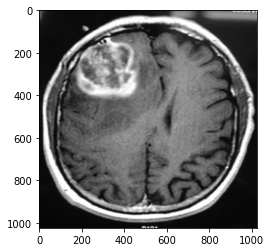

-------------------------------------------------------
Model identifying effected areas


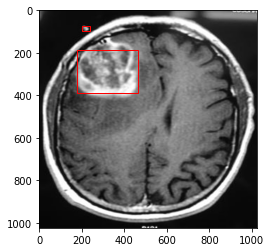

-------------------------------------------------------
Image before passing through model


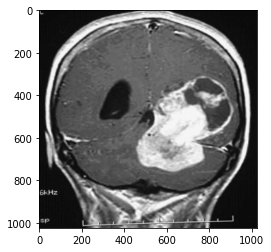

-------------------------------------------------------
Model identifying effected areas


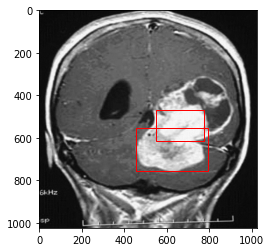

-------------------------------------------------------
Image before passing through model


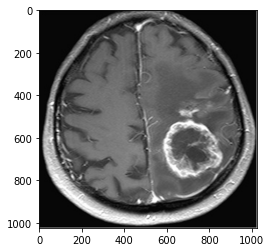

-------------------------------------------------------
Model identifying effected areas


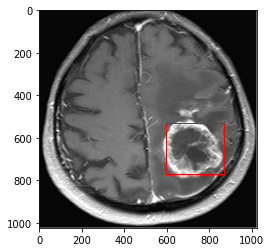

-------------------------------------------------------
Image before passing through model


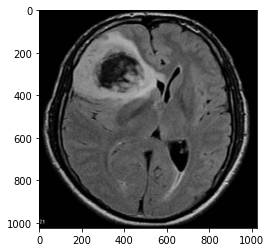

-------------------------------------------------------
Model identifying effected areas


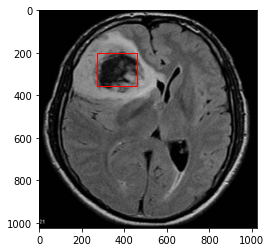

-------------------------------------------------------


In [21]:
sample = ['./brain-tumor/data/val/Y181.jpg', './brain-tumor/data/train/Y104.jpg', './brain-tumor/data/val/Y183.jpg', './brain-tumor/data/val/Y258.JPG' ]
boxes_predicted = []
for image in sample:
    imgloc = image
    img = cv2.imread(imgloc)
    res = cv2.resize(img, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
    r = model.detect([res], verbose=0)
    r = r[0]
    boxes_predicted.append(r['rois'])
    print("Image before passing through model")
    draw_image_with_boxes(res, [], [])
    print("-------------------------------------------------------")
    print("Model identifying effected areas")
    draw_image_with_boxes(res, r['rois'], r['scores'])
    print("-------------------------------------------------------")
    

# Number of tumors over 10 years for patient 1

(0.0, 12.0, 0.0, 7.0)

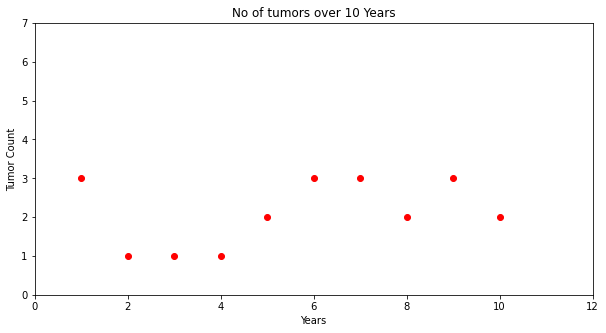

In [22]:
pid = 1.0
pdata = patients_data.loc[patients_data['patient_id'] == pid]
no_of_tumors = pdata['num_of_tumors']
plt.figure(figsize=(10,5))
plt.title('No of tumors over 10 Years')
plt.xlabel('Years')
plt.ylabel('Tumor Count')
plt.plot([1, 2, 3, 4, 5,6,7,8,9,10], no_of_tumors, 'ro')
plt.axis([0, 12, 0,7])
# plt.hist(no_of_tumors)

# Size of tumor 1 for patient 1 over 10 years 


(0.0, 11.0, 0.0, 150000.0)

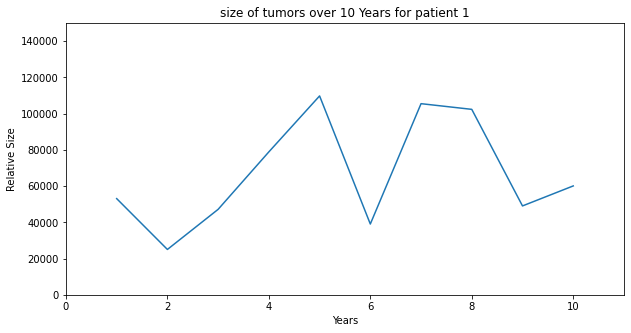

In [37]:
pid = 1.0
pdata = patients_data.loc[patients_data['patient_id'] == pid]
sizes = pdata['sizes']
plt.figure(figsize=(10,5))
plt.title('size of tumors over 10 Years for patient 1')
plt.xlabel('Years')
plt.ylabel('Relative Size')
size = []
for i in range(0,10):
    if no_of_tumors[i] > 1:
        size.append( sum ([ float(x) for x in (sizes[i].split(',')) ]) )
    elif no_of_tumors[i] == 0:
        size.append(float(0.0))
    else:
        size.append(float(sizes[i]))
size
# sizes
plt.plot([1, 2, 3, 4, 5,6,7,8,9,10], size)
plt.axis([0, 11, 0, 150000])

In [30]:

def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.

    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[2], boxes[1][2])
    y2 = np.minimum(box[3], boxes[1][3])
    x1 = np.maximum(box[0], boxes[1][0])
    x2 = np.minimum(box[1], boxes[1][1])
#     print(box[2], boxes[1][2], box[3], boxes[1][3], box[0], boxes[1][0], box[1], boxes[1][1])
    intersection = np.maximum(abs(x2 - x1), 0) * np.maximum(abs(y2 - y1), 0)
#     intersection = np.minimum(x2 - x1, 0) * np.minimum(y2 - y1, 0)
    union = box_area + boxes_area[1][0] - intersection
#     print(box_area ,boxes_area[1][0], intersection, union)
    if intersection > union:
        union, intersection = intersection, union
    iou = abs(intersection / union)
    if iou < 0.6:
        iou = 1 - iou
    return abs(iou)

In [39]:
original_boxes = []
def get_bboxes_original(image):
    if image.find("val"):
        im = (image.split("/")[-1]).split(".")[0]
        data = './brain-tumor/data/annotations_all.json'
        with open(data) as f:
            data_json = json.load(f)
        for key in data_json.keys():
            num = key.split(".")[0]
            if num == im:
                print(im)
#                 print(data_json[key])
                x = data_json[key]['regions'][0]['shape_attributes']['all_points_x']
                y = data_json[key]['regions'][0]['shape_attributes']['all_points_y']
                print("size", data_json[key]['size'])
                minx = min(x)
                maxx = max(x)
                miny = min(y)
                maxy = max(y)
                bbox = [[minx,miny, maxx, maxy]]
                original_boxes.append(bbox)
#                 img = cv2.imread(image)
#                 draw_image_with_boxes(img, bbox,[0.9] )
#                 print("-------------------------------------------------------")
                return bbox

In [40]:
def get_data(patients_data):
    images = patients_data['image']
    sample = ['./brain-tumor/data/val/Y181.jpg', './brain-tumor/data/train/Y104.jpg', './brain-tumor/data/val/Y183.jpg', './brain-tumor/data/val/Y258.JPG' ]
    original_boxes = []
    for image in sample:
        original_boxes.append(get_bboxes_original(image))
    return original_boxes

In [41]:
original_boxes = get_data(patients_data)

Y181
size 17045
Y104
size 98251
Y183
size 32581
Y258
size 23634


In [35]:
original_boxes, boxes_predicted

([[[55, 46, 141, 147]],
  [[311, 267, 636, 660]],
  [[171, 176, 253, 269]],
  [[77, 67, 144, 134]]],
 [array([[184, 175, 390, 462],
         [ 73, 199,  99, 236]], dtype=int32),
  array([[553, 456, 758, 795],
         [469, 551, 615, 776]], dtype=int32),
  array([[532, 598, 772, 867]], dtype=int32),
  array([[201, 272, 354, 460]], dtype=int32)])

In [62]:
box = boxes_predicted[0][0]
boxes = [1,original_boxes[0][0] ]
box_area = getarea(boxes_predicted[0][0])
print(box, boxes[1])

boxes_area = [1, [getarea(original_boxes[0][0])]]

compute_iou(box, boxes, box_area, boxes_area)

[184 175 390 462] [55, 46, 141, 147]
390 141 462 147 184 55 175 46


0.9784092898406955

In [86]:
i = 0
for item in boxes_predicted:
    box = item[0]
    boxes = [1,original_boxes[i][0] ]
    box_area = getarea(box)
    boxes_area = [1, [getarea(original_boxes[i][0])]]
    iou = compute_iou(box, boxes, box_area, boxes_area)
    i = i + 1
    print(iou)

0.9784092898406955
0.834342049269469
0.40312060222932067
0.8720149253731343
